# Multiple Shooting

In [1]:
import casadi as cs
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Das Single Shooting Verfahren (Einfachschießverfahren) basiert auf dem Prinzip der sequentiellen Simulation und Optimierung. Das System wird zunächst in Abhängigkeit der unbekannten Steuerfolge $\{\boldsymbol{u}_{k}\}_{k=0}^{N-1} = \{\boldsymbol{u}_{1},\boldsymbol{u}_{2},\dots,\boldsymbol{u}_{N-1} \}$ simuliert
\begin{align}
\boldsymbol{x}_{1} &= \boldsymbol{f}(\boldsymbol{x}_{0},\boldsymbol{u}_{0})\\
\boldsymbol{x}_{2} &= \boldsymbol{f}(\boldsymbol{x}_{1},\boldsymbol{u}_{1}) =  \boldsymbol{f}(\boldsymbol{f}(\boldsymbol{x}_{0},\boldsymbol{u}_{0}),\boldsymbol{u}_{1})\\
\boldsymbol{x}_{3} &= \boldsymbol{f}(\boldsymbol{x}_{2},\boldsymbol{u}_{2}) =  \boldsymbol{f}(\boldsymbol{f}(\boldsymbol{f}(\boldsymbol{x}_{0},\boldsymbol{u}_{0}),\boldsymbol{u}_{1}),\boldsymbol{u}_{2}) \\
\vdots &= \vdots
\end{align}

Lade bereits identifiziertes Modell

In [2]:
dyn_model = pkl.load(open('dyn_model.pkl','rb') )

f_model = dyn_model['f_model']
A_opt = dyn_model['A_opt']
B_opt = dyn_model['B_opt']
C_opt = dyn_model['C_opt']



Simuliere identifiziertes Modell immer nur einen einzigen Zeitschritt $\boldsymbol{x}_{k+1} = $  in Abhängigkeit eines unbekannten Anfangszustandes $\boldsymbol{s}_{k}$ und einer unbekannten Stellgröße $\boldsymbol{u}_{k}$
der . Die Kontinuität der Lösung wird erzwungen indem 
$$

$$

in Abhängigkeit einer unbekannten Steuerfolge

In [3]:
opti = cs.Opti()

N = 10

U = opti.variable(N-1,1)
S = opti.variable(2,N)

y_est = []
x_est = [S[:,0]]

for k in range(U.shape[0]):
    pred = f_model(u=U[k],x=x_est[-1],A=A_opt,B=B_opt,C=C_opt)
    
    x_est.append(pred['x_new'])
    
    opti.subject_to(x_est[-1] == S[:,k+1])

    y_est.append(pred['y'])

opti.subject_to(x_est[0] == np.zeros((2,1)))   

# Listen in Arrays konvertieren
y_est = cs.vcat(y_est)
x_est = cs.hcat(x_est)

Als Referenztrajektorie wird exemplarisch eine langsame Sinusschwingung gewählt

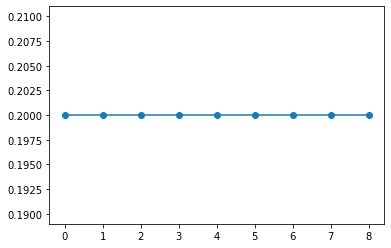

In [4]:
#y_ref = np.sin(1/300 * 2* np.pi *np.arange(0,N-1,1))
#y_ref = y_ref.reshape((-1,1))

y_ref =[[np.random.randint(-20,20)/10]*l[0] for l in np.random.randint(20,50,(10,1))]
y_ref = np.hstack(y_ref).reshape(-1,1)[0:N-1,:]
y_ref[0:10,:] = 0.2

plt.plot(y_ref,marker='o')

Die Bewertung der Differenz zwischen Referenztrajektorie und prädizierter Trajektorie erfolgt mittels einer Kostenfunktion

In [5]:
L = cs.sumsqr((y_ref - y_est))

opti.minimize(L)

opti.solver('ipopt')

#opti.set_initial(S,X_init)

#opti.set_initial(U,U_init)

sol = opti.solve()

U_opt = sol.value(U)
X_opt = sol.value(S)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      146
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       29
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

Simulate model for optimized input trajectory

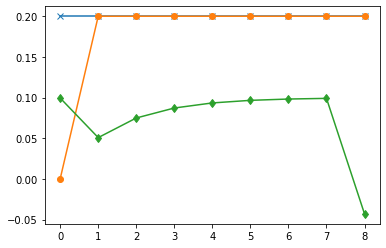

In [6]:
x_opt = [X_opt[:,0]]
y_opt = []

for k in range(U_opt.shape[0]):
    pred = f_model(u=U_opt[k],x=x_opt[-1],A=A_opt,B=B_opt,C=C_opt)
    
    x_opt.append(pred['x_new'])
    y_opt.append(pred['y'])

# opti.subject_to(S[0,:].T == np.array([[0],[0]]))    

# Listen in Arrays konvertieren
y_opt = cs.vcat(y_opt)
x_opt = cs.hcat(x_opt)



fig2,ax2 = plt.subplots(1,1)
#ax2.plot(x_opt.T,marker='d')
#ax2.plot(X_opt.T,marker='o')
#ax2.plot(U_opt.T,marker='x')
#ax2.plot(y_opt,marker='x')

ax2.plot(y_ref,marker='x')
ax2.plot(y_opt,marker='o')
ax2.plot(U_opt,marker='d')


Die Lösung des Optimalsteuerungsproblems basiert auf der Annahme, dass jede Stellgrößentrajektorie realisierbar ist. In praktischen Anwendungen existieren allerdings Beschränkungen bezüglich der realisierbaren Stellgrößen und Änderungen der Stellgrößen. Diese können durch Nebenbedingunen berücksichtigt werden: